# RGI19 (Antarctic and Subantarctic)

F. Maussion & S. Galos

Several changes to RGI6

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, open_zip_shapefile, find_duplicates, find_neighbors, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 19

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '19_rgi60_AntarcticSubantarctic.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
71,1,11.2,Rau,Rau,2005,Antarctic Peninsula,2001,2001,2001
94,1,58.8,Rau,Rau,2005,Antarctic Peninsula,2001,2001,2001
95,1,128.7,Rau,Rau,2005,Antarctic Peninsula,2001,2001,2001
96,1,80.5,Rau,Rau,2005,Antarctic Peninsula,2001,2001,2001
472,1,7380.9,Glasser,Glasser,2008,Various (NSIDC),2000,2000,2000
525,27,707.5,Mabileau,Berthier,2009,Kerguelen Island and other Antarctic Periphery,1963,1963,1963
526,129,4.8,Mabileau,Mabileau,2009,Kerguelen Island and other Antarctic Periphery,1994,1994,1994
527,91,39.3,Mabileau,Mabileau,2009,Kerguelen Island and other Antarctic Periphery,2001,2001,2001
528,126,494.6,Mabileau,Mabileau,2009,Kerguelen Island and other Antarctic Periphery,2001,2001,2001


- 585 is the RGI6
- 700 is a better quality inventory for the South Sandwich Islands in 19-03
- 769 is a better quality Kerguelen inventory
- 798 is a better inventory for subregions 19-12 and 19-13 (we remove 19-12 which has been mapped by 798)
- 805 is a better inventory for subregions 19-14 and 19-24
- 806 is a better inventory for subregions 19-11 and 19-12
- 807 is a better inventory for subregions 19-01, 19-05, 19-17, and parts of 19-02 (South Orkney Islands)
- 808 is a better quality inventory for the Bouvet Island in 19-03
- 811 is a better inventory for subregions 19-15 and 19-16

In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [6]:
s_585 = shp.loc[shp['subm_id']==585].copy()
s_585['is_rgi6'] = True

In [7]:
s_700 = shp.loc[shp['subm_id']==700].copy()
s_700['is_rgi6'] = False

In [8]:
s_769 = shp.loc[shp['subm_id']==769].copy()
s_769['is_rgi6'] = False

In [9]:
s_798 = shp.loc[shp['subm_id']==798].copy()
s_798['is_rgi6'] = False

In [10]:
s_805 = shp.loc[shp['subm_id']==805].copy()
s_805['is_rgi6'] = False

In [11]:
s_806 = shp.loc[shp['subm_id']==806].copy()
s_806['is_rgi6'] = False

In [12]:
s_807 = shp.loc[shp['subm_id']==807].copy()
s_807['is_rgi6'] = False

In [13]:
s_808 = shp.loc[shp['subm_id']==808].copy()
s_808['is_rgi6'] = False

In [14]:
s_811 = shp.loc[shp['subm_id']==811].copy()
s_811['is_rgi6'] = False

### Kerguelen 

In [15]:
# Read box containing glaciers with subm_id = 769
box = open_zip_shapefile(data_dir + f'/l0_support_data/kerguelen.zip')

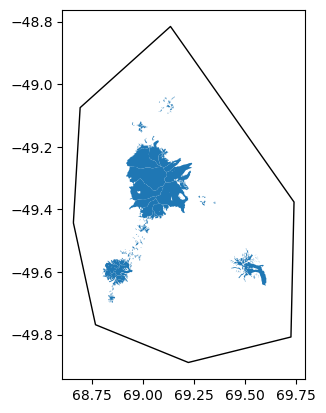

In [16]:
# Plot correct glaciers and shapefile
base = box.plot(color='none', edgecolor='black')
s_769.geometry.plot(ax=base, color='C0', markersize=5);

Now we remove the glaciers inside from the other one:

In [17]:
# Save glacier centroid in rp:
rp = s_585.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = s_585.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporary variable
s_585_sel = s_585.loc[difference['orig_index']]

len(s_585) - len(s_585_sel), len(s_769)

(145, 363)

In [18]:
s_585 = s_585_sel

### South Orkney 

In [19]:
# Read box
box = open_zip_shapefile(data_dir + f'/l0_support_data/south-orkney.zip')

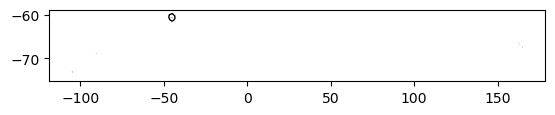

In [20]:
# Plot correct glaciers and shapefile
base = box.plot(color='none', edgecolor='black')
s_807.geometry.plot(ax=base, color='C0', markersize=5);

Now we remove the glaciers inside from the other one:

In [21]:
# Save glacier centroid in rp:
rp = s_585.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = s_585.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporary variable
s_585_sel = s_585.loc[difference['orig_index']]

len(s_585) - len(s_585_sel)

141

In [22]:
s_585 = s_585_sel

### South Sandwich 

In [23]:
# Read box containing glaciers with subm_id = 769
box = open_zip_shapefile(data_dir + f'/l0_support_data/Sandwich-Islands.zip')

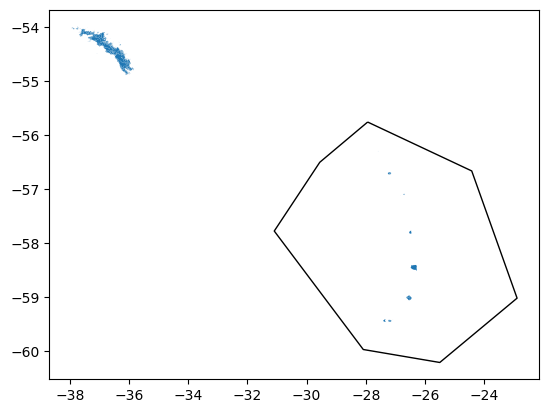

In [24]:
# Plot correct glaciers and shapefile
base = box.plot(color='none', edgecolor='black')
s_700.geometry.plot(ax=base, color='C0', markersize=5);

Now we keep the glaciers inside the box and remove the ones from RGI6:

In [25]:
# Save glacier centroid in rp:
rp = s_700.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = s_700.index

# Find overlying polygons
intersection = gpd.overlay(rp, box, how='intersection')

# Create temporary variable
s_700_sel = s_700.loc[intersection['orig_index']]

len(s_700_sel) - len(s_700), len(s_700_sel)

(-921, 31)

In [26]:
# Save glacier centroid in rp:
rp = s_585.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = s_585.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporary variable
s_585_sel = s_585.loc[difference['orig_index']]

len(s_585) - len(s_585_sel), len(s_700_sel)

(29, 31)

In [27]:
s_585 = s_585_sel
s_700 = s_700_sel

### Bouvet

In [28]:
# Read box
box = open_zip_shapefile(data_dir + f'/l0_support_data/bouvet.zip')

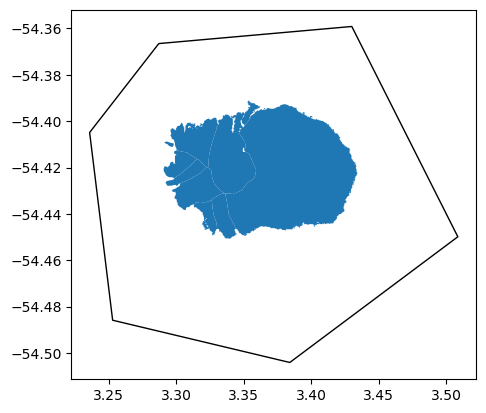

In [29]:
# Plot correct glaciers and shapefile
base = box.plot(color='none', edgecolor='black')
s_808.geometry.plot(ax=base, color='C0', markersize=5);

Now we remove the glaciers inside from the other one:

In [30]:
# Save glacier centroid in rp:
rp = s_585.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = s_585.index

# Find non overlying polygons
difference = gpd.overlay(rp, box, how='difference')

# Create temporary variable
s_585_sel = s_585.loc[difference['orig_index']]

len(s_585) - len(s_585_sel)

16

In [31]:
s_585 = s_585_sel

### Remove duplacted outline 19-12

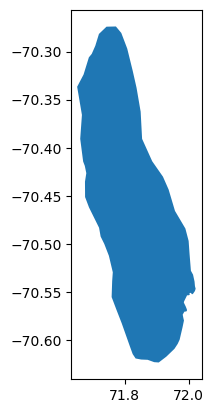

In [32]:
s_798.loc[s_798.anlys_id == 995059].plot();

In [33]:
s_798 = s_798.loc[s_798.anlys_id != 995059].copy()

### New subregions outlines 

In [34]:
# Read subregs
sregs = open_zip_shapefile(os.path.join(data_dir, '00_rgi70_regions/00_rgi70_O2Regions.zip'))

In [35]:
sregs_sel = sregs.loc[sregs.o2region.isin(['19-01', '19-05', '19-11', '19-12', '19-13', '19-14', '19-15', '19-16', '19-17', '19-24'])]
sregs_sel

,o1region,o2region,full_name,long_code,geometry
70,19,19-01,Subantarctic (Pacific),19-01_subantarctic_pacific,"POLYGON ((-180.00000 -70.50000, -180.00000 -69..."
74,19,19-05,Balleny Islands,19-05_balleny_islands,"POLYGON ((161.00000 -68.40000, 161.00000 -68.0..."
75,19,19-11,East Queen Maud Land 7A,19-11_east_queen_maud_land_7a,"POLYGON ((54.50000 -65.84225, 54.35023 -65.848..."
76,19,19-12,Amery Ice Shelf 7B,19-12_amery_ice_shelf_7b,"POLYGON ((70.10000 -64.00000, 71.00000 -64.000..."
77,19,19-13,Wilkes Land 7C,19-13_wilkes_land_7c,"POLYGON ((105.50000 -66.18248, 105.24969 -66.1..."
78,19,19-14,Victoria Land 7D,19-14_victoria_land_7d,"POLYGON ((166.00000 -74.70000, 166.00000 -74.9..."
79,19,19-15,Ross Ice Shelf 7E,19-15_ross_ice_shelf_7e,"POLYGON ((-180.00000 -74.70000, -179.50000 -74..."
80,19,19-15,Ross Ice Shelf 7E,19-15_ross_ice_shelf_7e,"POLYGON ((180.00000 -84.35805, 179.94540 -84.3..."
81,19,19-16,Marie Byrd Land 7F,19-16_marie_byrd_land_7f,"POLYGON ((-114.10000 -71.00000, -114.10000 -71..."
82,19,19-17,Pine Island Bay 7G,19-17_pine_island_bay_7g,"POLYGON ((-103.17850 -75.04130, -103.23780 -75..."


In [36]:
# Save glacier centroid in rp:
rp = s_585.representative_point()

rp = rp.to_frame('geometry')
rp['orig_index'] = s_585.index

# Find non overlying polygons
difference = gpd.overlay(rp, sregs_sel, how='difference')

# Create temporary variable
s_585_sel = s_585.loc[difference['orig_index']]

len(s_585) - len(s_585_sel)

626

In [37]:
s_585 = s_585_sel

### OK Merge 

In [38]:
# Merge original RGI and the new invs
rgi7 = pd.concat([s_585, s_700, s_769, s_798, s_805, s_806, s_807, s_808, s_811])

In [39]:
# Size filter?
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

2708
2664


### Some sanity checks 

In [40]:
dupes = find_duplicates(rgi7)

Potential duplicates: 3


In [42]:
rgi7 = rgi7.loc[rgi7.anlys_id != dupes.iloc[1].anlys_id]
dupes = find_duplicates(rgi7)

Potential duplicates: 1


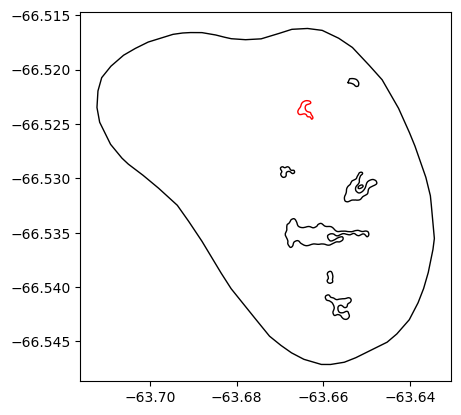

In [45]:
nn = find_neighbors(dupes, rgi7, n=2)
f, ax = plt.subplots()
nn.iloc[[1]].plot(ax=ax, edgecolor='k', facecolor='none');
dupes.plot(ax=ax, edgecolor='r', facecolor='none');

OK so this is obviously a misclassified rock outcrop: https://trello.com/c/UGyLbC87

Lets delete:

In [46]:
rgi7 = rgi7.loc[rgi7.anlys_id != 287466]
find_duplicates(rgi7);

Seems Okay!


In [47]:
rgi7 = correct_geoms(rgi7)

Found 17 invalid geometries out of 2662. Correcting...
After correction, 0 geometries are still invalid.
Area changed by -434.4 m2 (-0.0000%)


In [48]:
needs_size_filter(rgi7)

False

In [49]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA,N Moutain gl,N 10?,N Ice cap,N Ice-field,N Outlet gl,N Glacieret
subm_id,,,,,,,,
585,1794,1568,108,67,42,3,6,0
700,31,0,2,0,26,0,0,3
769,340,340,0,0,0,0,0,0
798,7,7,0,0,0,0,0,0
805,69,69,0,0,0,0,0,0
806,23,23,0,0,0,0,0,0
807,213,213,0,0,0,0,0,0
808,11,11,0,0,0,0,0,0
811,174,174,0,0,0,0,0,0


In [50]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area
        orphan_f = orphan_f.loc[orphan_f.subm_id.isin(rgi7.subm_id.unique()[check])]

Orphan rock outcrops detected in subm_id [585. 700.]


In [51]:
orphan_f['area'].sum() * 1e-6

0.0692562351391598

### Plots 

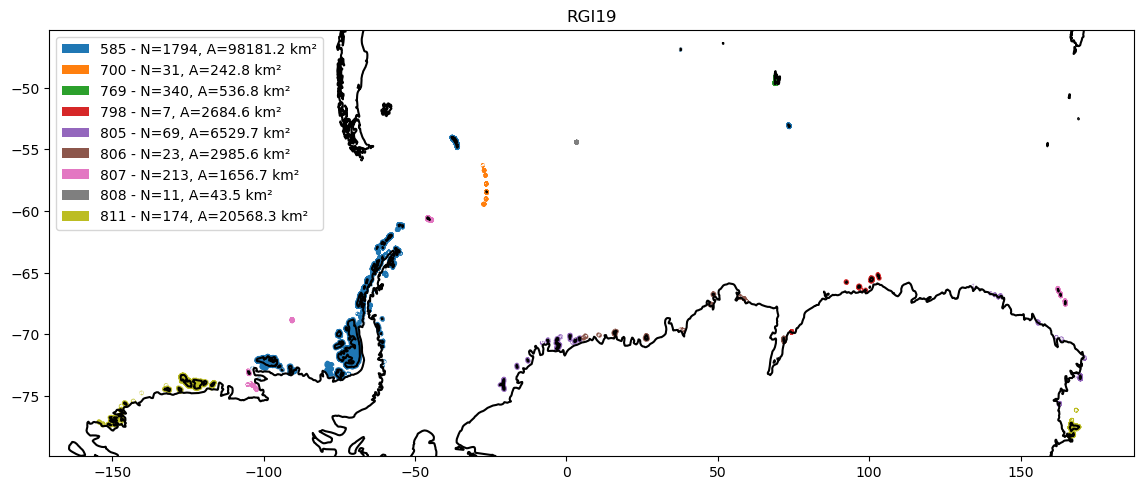

In [52]:
plot_map(rgi7, reg, linewidth=3, loc='upper left')

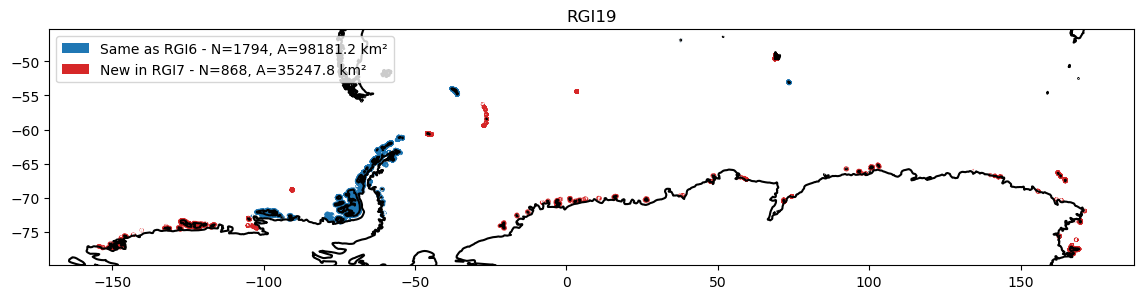

In [53]:
plot_map(rgi7, reg, linewidth=3, is_rgi6=True, loc='upper left')

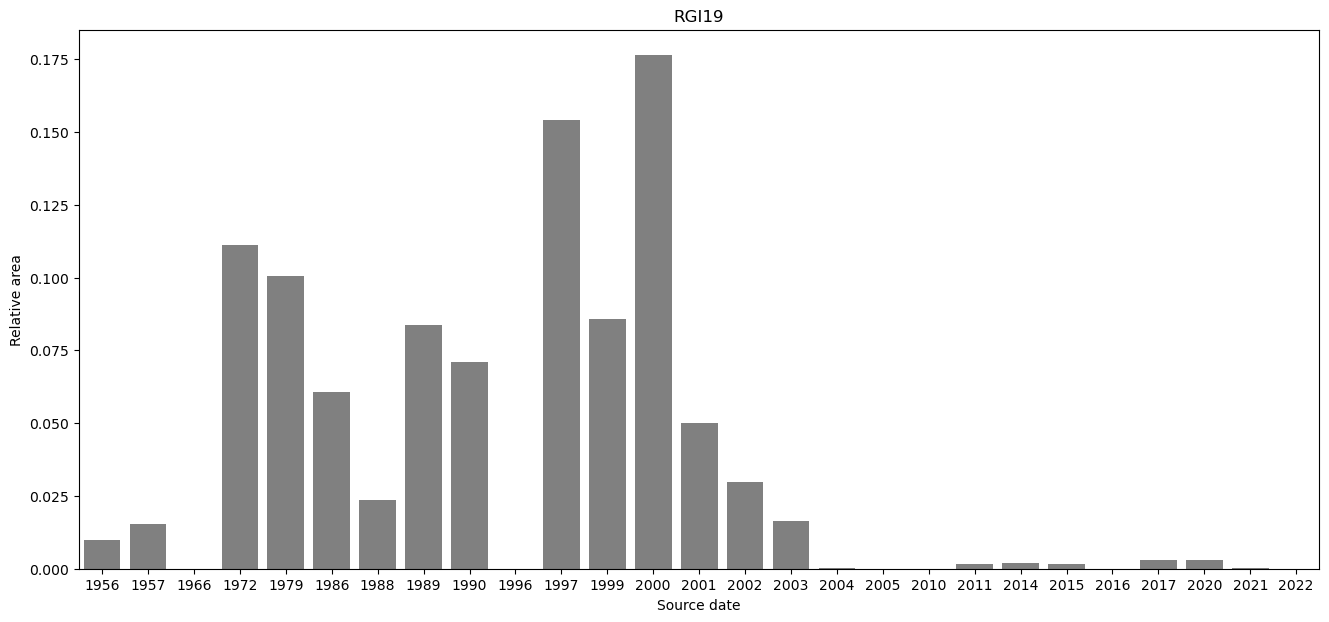

In [54]:
plot_date_hist(rgi7, reg, figsize=(16, 7))

### Text for github

In [55]:
fgh = sdf.T
fgh

subm_id,585,700,769,798,805,806,807,808,811
N,1794,31,340,7,69,23,213,11,174
A,98181.2,242.8,536.8,2684.6,6529.7,2985.6,1656.7,43.5,20568.3
analysts,"Berthier, Bliss, Cogley, LeBris, Paul","Castro, Gargantini, Gimenez, Hidalgo, Masiokas...","Mabileau, Paul, Rastner","Berthier, Lebreton",McNabb,McNabb,"Cha, Gould, Kochtitzky, Merrill",Kochtitzky,McNabb
submitters,Bliss,Hidalgo,Paul,Berthier,McNabb,McNabb,Kochtitzky,Kochtitzky,McNabb
release_date,2015,2018,2022,2022,2022,2022,2022,2022,2022
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,Argentina,Kerguelen Island and other Antarctic Periphery,Kerguelen Island and other Antarctic Periphery,Kerguelen Island and other Antarctic Periphery,Kerguelen Island and other Antarctic Periphery,Kerguelen Island and other Antarctic Periphery,Kerguelen Island and other Antarctic Periphery,Kerguelen Island and other Antarctic Periphery
src_date_mode,2003,2011,2001,2002,2000,2000,2020,2021,2000
src_date_min,1956,2004,2001,2000,1999,2000,1997,2021,1999
src_date_max,2005,2017,2022,2002,2000,2002,2020,2021,2000


In [56]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 585                                                                    | 700                                                                                   | 769                                            | 798                                            | 805                                            | 806                                            | 807                                            | 808                                            | 811                                            |
|:--------------|:-----------------------------------------------------------------------|:--------------------------------------------------------------------------------------|:-----------------------------------------------|:-----------------------------------------------|:-----------------------------------------------|:-----------------------------------------------|:-----------------------------------------------|:-----------------------------------------------|:-----

## Write out and tar 

In [57]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI19/
RGI19/RGI19.prj
RGI19/RGI19.cpg
RGI19/RGI19.shx
RGI19/RGI19.dbf
RGI19/RGI19.shp
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI19.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI19'], returncode=0)


## Consistency check with RGI6 

Much harder to do now given the complexity

#### load reference data (here RGI6 original) to enable comparison

In [60]:
# load reference data
from utils import open_zip_shapefile
ref_odf = open_zip_shapefile(rgi6_reg_file)

#### Number of elements (differences do not depict problems)

In [61]:
print('Number of glaciers in new RGI subset:', len(rgi7))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(rgi7)-len(ref_odf))

Number of glaciers in new RGI subset: 2648
Number of glaciers in reference data: 2752
Difference: -104


#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [62]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

0

#### Total area

In [63]:
# add an area field to RGI_ss and reference data
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [65]:
# print and compare area values
Area_Rep = rgi7['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
d = (Area_Rep - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 132367.48796226407
Area RGI6 [km²]: 132867.1533679446
Area difference [km²]: -499.6654056805128 / percentage: -0.37748348433035134
